In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm as tqdm, trange
from dataclasses import dataclass, field
from typing import Tuple, List, Any
from functools import partial
import pickle


%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams.update({'font.size': 14})

trange = partial(trange, position=0)
tqdm = partial(tqdm, position=0)

# Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован
Environment для крестиков-ноликов, в котором можно при инициализации указывать
разные размеры доски и условия победы, а также функции для рисования, в том числе с
указанием оценки различных действий. С этим окружением все задания и связаны.

## Пункт 1
Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и
ноликов для доски 3х3.

In [2]:
from tic_tac_toe import TicTacToe
from contracts import State, Action, Strategy, RandomStrategy, TicTacToeWrapper
from qlearning import TableState, TicTacToeTableWrapper

In [3]:
env = TicTacToeTableWrapper(TicTacToe(3,3,3))

In [4]:
def show_test_game(env: TicTacToeWrapper,
                    crosses_strategy: Strategy,
                    naughts_strategy: Strategy,
                    show_only_final: bool = False):
    '''Играем тестовую партию между стратегиями, печатаем ход игры'''
    state, actions = env.reset()
    while True:
        if env.env.curTurn == 1:
            action = crosses_strategy.get_action(state, actions)
        else:
            action = naughts_strategy.get_action(state, actions)
        state, actions, crosses_reward, done = env.step(action)
        if not show_only_final:
            env.env.printBoard()
            print()
        if crosses_reward == 1:
            if show_only_final:
                env.env.printBoard()
            print("Крестики выиграли!")
            return
        if crosses_reward == -1:
            if show_only_final:
                env.env.printBoard()
            print("Нолики выиграли!")
            return
        if done:
            if show_only_final:
                env.env.printBoard()
            print("Ничья!")
            return

In [5]:
random_strategy = RandomStrategy()

In [6]:
show_test_game(env, random_strategy, random_strategy)

---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x |   | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -
| o |   | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x |   | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x

In [7]:
show_test_game(env, random_strategy, random_strategy, True)

---- ---- ---- -
| x | x |   | 
---- ---- ---- -
| x |   | o | 
---- ---- ---- -
| x | o | o | 
---- ---- ---- -
Крестики выиграли!


In [8]:
show_test_game(env, random_strategy, random_strategy, True)

---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| x | o | o | 
---- ---- ---- -
Крестики выиграли!


## Сначала научимся обыгрывать случайную стратегию на поле 3x3
Обучать будем одну и ту же Q-функцию как для крестиков, так и для ноликов.  
Обновление Q-функции реализовано в классе `RunningExp`: он хранит пары (ключ, значение), а при добавлении нового элемента реализует экспоненциальное сглаживание с заданным параметром `alpha`.  
Для повышения эффективности обучения будем заменять пары (состояние, действие) на один afterstate. Это делается прозрачно с помощью класса `AfterstatesTableFunctionWrapper`

In [9]:
from table_functions import TableFunction, RunningExp
from qlearning import EpsilonGreedyStrategy, Afterstate, AfterstatesTableFunctionWrapper

In [10]:
print(TableFunction.__doc__)

Родительский класс для итеративно обновляемых табличных функций


In [11]:
print(RunningExp.__doc__)

Выполняет итеративное экспоненциальное сглаживание значений value для каждого key


In [12]:
print(AfterstatesTableFunctionWrapper.__doc__)

Проксирует обращения к TableFunction, заменяя пару (состояние, действие)
    на afterstate


In [13]:
@dataclass
class GameResults:
    crosses_reward: int
    naughts_reward: int
    crosses_state_actions: List[Tuple[State, Action]]
    naughts_state_actions: List[Tuple[State, Action]]

In [14]:
def run_episode_for_Q(env: TicTacToeWrapper,
                        crosses_strategy: Strategy,
                        naughts_strategy: Strategy) -> GameResults:
    """Генерирует эпизод по двум стратегиям, возвращает финальные reward'ы для крестиков и ноликов,
    а также списки пар (состояние, действие)"""
    crosses_state_actions = []
    naughts_state_actions = []
    state, actions = env.reset()
    while True:
        if env.env.curTurn == 1:
            action = crosses_strategy.get_action(state, actions)
            crosses_state_actions.append((state, action))
        else:
            action = naughts_strategy.get_action(state, actions)
            naughts_state_actions.append((state, action))
        state, actions, crosses_reward, done = env.step(action)
        if done:
            return GameResults(crosses_reward, -crosses_reward, crosses_state_actions, naughts_state_actions)

In [15]:
@dataclass
class EvaluationResults:
    crosses_mean_reward: float
    naughts_mean_reward: float
    crosses_win_fraction: float
    naughts_win_fraction: float
    tie_fraction: float

In [16]:
def evaluate_strategy(env: TicTacToeWrapper,
                        crosses_strategy: Strategy,
                        naughts_strategy: Strategy,
                        num_iterations: int) -> EvaluationResults:
    """Генерирует num_iterations запусков по двум стратегиям
    и возвращает итоговые результаты"""
    crosses_rewards = [run_episode_for_Q(env, crosses_strategy, naughts_strategy).crosses_reward
               for _ in trange(num_iterations)]
    crosses_rewards = np.array(crosses_rewards)
    crosses_mean_reward = crosses_rewards.mean()
    naughts_mean_reward = -crosses_mean_reward
    crosses_win_fraction = (crosses_rewards == 1).mean()
    naughts_win_fraction = (crosses_rewards == -1).mean()
    tie_fraction = (crosses_rewards == 0).mean()
    return EvaluationResults(crosses_mean_reward, naughts_mean_reward,
                             crosses_win_fraction, naughts_win_fraction, tie_fraction)

Протестируем код на случайных стратегиях.  
Должны получить вероятность победы крестиков - 0.585, ноликов - 0.288, ничьей - 0.127

In [17]:
evaluate_strategy(env, random_strategy, random_strategy, 50000)

100%|██████████| 50000/50000 [00:40<00:00, 1220.22it/s]


EvaluationResults(crosses_mean_reward=0.2957, naughts_mean_reward=-0.2957, crosses_win_fraction=0.58342, naughts_win_fraction=0.28772, tie_fraction=0.12886)

Всё сходится. Теперь приступим к обучению

In [18]:
def update_q_function(strategy: EpsilonGreedyStrategy,
                      state_actions: List[Tuple[TableState, Action]],
                      reward: int):
    Q = strategy.Q
    #  Поскольку задача эпизодическая, можем обновлять с конца
    #  Также учитываем, что ненулевой реворд есть только для последнего состояния,
    #  gamma==1,
    #  RunningExp внутри EpsilonGreedyStrategy автоматически учитывает веса alpha и 1-alpha
    reversed_state_actions = list(reversed(state_actions))
    last_state, last_action = reversed_state_actions[0]
    Q.update((last_state, last_action), reward)
    next_state = last_state
    for state, action in reversed_state_actions[1:]:
        best_next_action = strategy._get_best_action(next_state, next_state.available_actions)
        update = Q[(next_state, best_next_action)]
        Q.update((state, action), update)
        next_state = state

In [19]:
class QlearningTrainer:
    """Реализует алгоритм Q-learning. Обучаем train_strategy играть против opponent_strategy"""

    def __init__(self,
                 env: TicTacToeWrapper,
                 train_strategy: EpsilonGreedyStrategy,
                 opponent_strategy: Strategy):
        self.env = env
        self.train_strategy = train_strategy
        self.opponent_strategy = opponent_strategy

    def fit(self, num_iterations: int) -> EpsilonGreedyStrategy:
        Q = self.train_strategy.Q
        for _ in trange(num_iterations):
            #  Определяем, за какую сторону будем играть в этот раз
            train_crosses = np.random.rand() < 0.5
            if train_crosses:
                game_results = run_episode_for_Q(self.env, self.train_strategy, self.opponent_strategy)
                reward = game_results.crosses_reward
                state_actions = game_results.crosses_state_actions
            else:
                game_results = run_episode_for_Q(self.env, self.opponent_strategy, self.train_strategy)
                reward = game_results.naughts_reward
                state_actions = game_results.naughts_state_actions

            update_q_function(self.train_strategy, state_actions, reward)
        return self.train_strategy

    def __repr__(self) -> str:
        return f'QlearningTrainer(epsilon={self.train_strategy.epsilon}, alpha={self.train_strategy.Q.alpha})'

In [20]:
@dataclass
class TrainHistory:
    crosses_mean_rewards: List[float] = field(default_factory=list)
    naughts_mean_rewards: List[float] = field(default_factory=list)
    crosses_win_fractions: List[float] = field(default_factory=list)
    naughts_win_fractions: List[float] = field(default_factory=list)
    tie_fractions: List[float] = field(default_factory=list)
       
    def append(self, result: EvaluationResults):
        self.crosses_mean_rewards.append(result.crosses_mean_reward)
        self.naughts_mean_rewards.append(result.naughts_mean_reward)
        self.crosses_win_fractions.append(result.crosses_win_fraction)
        self.naughts_win_fractions.append(result.naughts_win_fraction)
        self.tie_fractions.append(result.tie_fraction)

In [21]:
def train_and_eval(trainer: QlearningTrainer,
                    train_iterations: int,
                    eval_iterations: int,
                    num_checkpoints: int) -> Tuple[TrainHistory, TrainHistory]:
    """Обучает Q-функцию с помощью trainer, оценивая в процессе жадную стратегию,
    играющую по обученной Q. На каждом чекпоинте прогоняем eval_iterations запусков
    с жадной стратегией."""
    #  Обучать будем по эпохам, оценивая качество после каждой из них
    epoch_iterations = int(train_iterations / num_checkpoints)
    crosses_history = TrainHistory()
    naughts_history = TrainHistory()
    print(f'Trainer: {trainer}', flush=True)
    print(f'Training {trainer.train_strategy} versus {trainer.opponent_strategy}', flush=True)
    for epoch in trange(num_checkpoints, desc='Epoch'):
        print(f'Epoch {epoch+1} of {num_checkpoints} ({epoch_iterations} runs)', flush=True)
        trained_strategy = trainer.fit(epoch_iterations)
        eval_strategy = EpsilonGreedyStrategy(epsilon=0, Q=trained_strategy.Q)
        crosses_results = evaluate_strategy(trainer.env,
                        crosses_strategy=eval_strategy,
                        naughts_strategy=trainer.opponent_strategy,
                        num_iterations=eval_iterations)
        crosses_history.append(crosses_results)
        print(f'{eval_strategy} results over {eval_iterations} eval iterations as crosses:', flush=True)
        print(crosses_results, flush=True)
        print(flush=True)
        naughts_results = evaluate_strategy(trainer.env,
                        crosses_strategy=trainer.opponent_strategy,
                        naughts_strategy=eval_strategy,
                        num_iterations=eval_iterations)
        naughts_history.append(naughts_results)
        print(f'{eval_strategy} results over {eval_iterations} eval iterations as naughts:', flush=True)
        print(naughts_results)
        print('\n', flush=True)
    return crosses_history, naughts_history

In [22]:
EPSILON = 0.5
ALPHA = 0.1

In [23]:
Q = AfterstatesTableFunctionWrapper(RunningExp(alpha=ALPHA))

In [24]:
train_strategy = EpsilonGreedyStrategy(epsilon=EPSILON, Q=Q)

In [25]:
opponent_strategy = RandomStrategy()

In [26]:
trainer = QlearningTrainer(env, train_strategy, opponent_strategy)

In [27]:
TRAIN_ITER = 250000
EVAL_ITER = 50000
NUM_CHECKPOINTS = 5

In [28]:
crosses_history, naughts_history = train_and_eval(trainer,
                        TRAIN_ITER,
                        EVAL_ITER,
                        NUM_CHECKPOINTS)

Trainer: QlearningTrainer(epsilon=0.5, alpha=0.1)
Training EpsilonGreedyStrategy(epsilon=0.5) versus RandomStrategy


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:46<00:00, 1083.40it/s]

GreedyStrategy results over 50000 eval iterations as crosses:
EvaluationResults(crosses_mean_reward=0.99006, naughts_mean_reward=-0.99006, crosses_win_fraction=0.99006, naughts_win_fraction=0.0, tie_fraction=0.00994)




100%|██████████| 50000/50000 [00:46<00:00, 1066.05it/s]

GreedyStrategy results over 50000 eval iterations as naughts:


EvaluationResults(crosses_mean_reward=-0.90506, naughts_mean_reward=0.90506, crosses_win_fraction=0.0207, naughts_win_fraction=0.92576, tie_fraction=0.05354)




Epoch:  20%|██        | 1/5 [02:28<09:52, 148.17s/it]

Epoch 2 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:45<00:00, 1088.48it/s]

GreedyStrategy results over 50000 eval iterations as crosses:
EvaluationResults(crosses_mean_reward=0.98912, naughts_mean_reward=-0.98912, crosses_win_fraction=0.98912, naughts_win_fraction=0.0, tie_fraction=0.01088)




100%|██████████| 50000/50000 [00:48<00:00, 1039.08it/s]

GreedyStrategy results over 50000 eval iterations as naughts:
EvaluationResults(crosses_mean_reward=-0.9106, naughts_mean_reward=0.9106, crosses_win_fraction=0.0147, naughts_win_fraction=0.9253, tie_fraction=0.06)





Epoch:  40%|████      | 2/5 [04:57<07:25, 148.65s/it]

Epoch 3 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:50<00:00, 996.49it/s] 


GreedyStrategy results over 50000 eval iterations as crosses:
EvaluationResults(crosses_mean_reward=0.98936, naughts_mean_reward=-0.98936, crosses_win_fraction=0.98936, naughts_win_fraction=0.0, tie_fraction=0.01064)



100%|██████████| 50000/50000 [00:46<00:00, 1082.11it/s]

GreedyStrategy results over 50000 eval iterations as naughts:
EvaluationResults(crosses_mean_reward=-0.8907, naughts_mean_reward=0.8907, crosses_win_fraction=0.02186, naughts_win_fraction=0.91256, tie_fraction=0.06558)





Epoch:  60%|██████    | 3/5 [07:29<04:58, 149.49s/it]

Epoch 4 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:46<00:00, 1074.20it/s]


GreedyStrategy results over 50000 eval iterations as crosses:
EvaluationResults(crosses_mean_reward=0.98944, naughts_mean_reward=-0.98944, crosses_win_fraction=0.98944, naughts_win_fraction=0.0, tie_fraction=0.01056)



100%|██████████| 50000/50000 [00:47<00:00, 1049.46it/s]

GreedyStrategy results over 50000 eval iterations as naughts:
EvaluationResults(crosses_mean_reward=-0.91552, naughts_mean_reward=0.91552, crosses_win_fraction=0.01052, naughts_win_fraction=0.92604, tie_fraction=0.06344)





Epoch:  80%|████████  | 4/5 [09:57<02:28, 148.95s/it]

Epoch 5 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:44<00:00, 1113.48it/s]


GreedyStrategy results over 50000 eval iterations as crosses:
EvaluationResults(crosses_mean_reward=0.9952, naughts_mean_reward=-0.9952, crosses_win_fraction=0.9952, naughts_win_fraction=0.0, tie_fraction=0.0048)



100%|██████████| 50000/50000 [00:44<00:00, 1128.65it/s]


GreedyStrategy results over 50000 eval iterations as naughts:
EvaluationResults(crosses_mean_reward=-0.92102, naughts_mean_reward=0.92102, crosses_win_fraction=0.0041, naughts_win_fraction=0.92512, tie_fraction=0.07078)




Epoch: 100%|██████████| 5/5 [12:21<00:00, 148.39s/it]


In [29]:
def save(obj: Any, path: str):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def load(path) -> Any:
    with open(path, 'rb') as f:
        return pickle.load(f)

In [30]:
path = 'models/random_train_q_3x3.pkl'
save(trainer.train_strategy.Q, path)
# Проверяем, что всё работает
trainer.train_strategy.Q = load(path)

In [31]:
def plot_history(history: TrainHistory,
                 title: str,
                 train_iterations: int,
                 eval_iterations: int,
                 num_checkpoints: int):
    """Отрисовывает результаты обучения"""
    x_values = np.linspace(train_iterations/num_checkpoints, train_iterations, num_checkpoints)
    plt.figure(figsize=(15, 7))
    plt.plot(x_values, history.crosses_mean_rewards, label='Средний reward крестиков')
    plt.plot(x_values, history.naughts_mean_rewards, label='Средний reward ноликов')
    plt.plot(x_values, history.crosses_win_fractions, label='Доля побед крестиков')
    plt.plot(x_values, history.naughts_win_fractions, label='Доля побед ноликов')
    plt.plot(x_values, history.tie_fractions, label='Доля ничьих')
    plt.title(title, fontsize=16)
    plt.xlabel('Число итераций обучения', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()

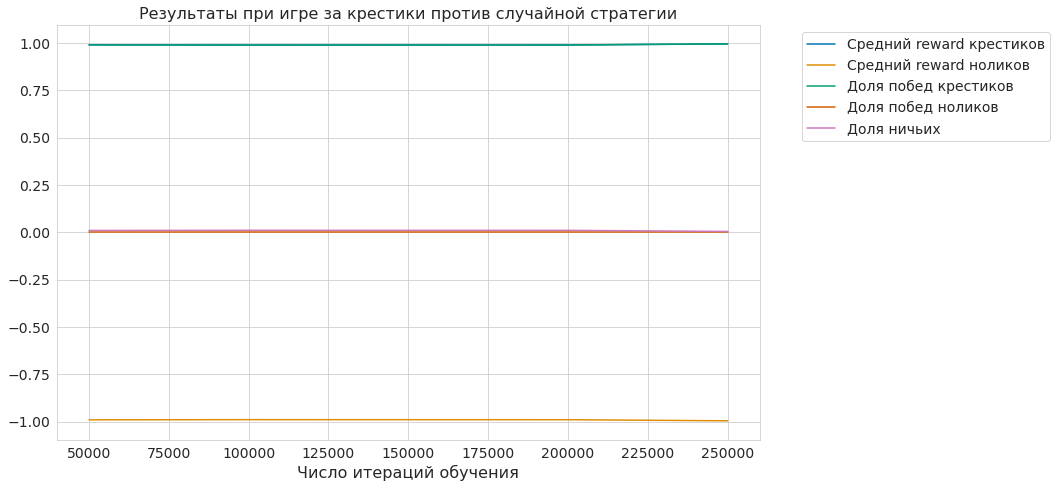

In [32]:
plot_history(crosses_history,
            'Результаты при игре за крестики против случайной стратегии',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

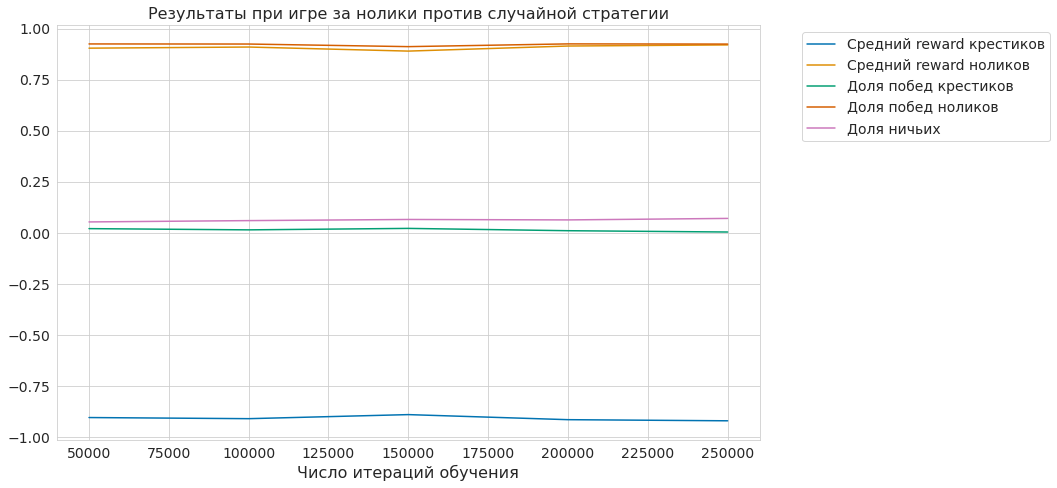

In [33]:
plot_history(naughts_history,
            'Результаты при игре за нолики против случайной стратегии',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

In [34]:
print('Доли поражений при игре за нолики')
naughts_history.crosses_win_fractions

Доли поражений при игре за нолики


[0.0207, 0.0147, 0.02186, 0.01052, 0.0041]

In [35]:
greedy_strategy = EpsilonGreedyStrategy(0, trainer.train_strategy.Q)

In [36]:
evaluate_strategy(env, crosses_strategy=greedy_strategy, naughts_strategy=random_strategy, num_iterations=EVAL_ITER)

100%|██████████| 50000/50000 [00:45<00:00, 1108.35it/s]


EvaluationResults(crosses_mean_reward=0.99448, naughts_mean_reward=-0.99448, crosses_win_fraction=0.99448, naughts_win_fraction=0.0, tie_fraction=0.00552)

In [37]:
evaluate_strategy(env, crosses_strategy=random_strategy, naughts_strategy=greedy_strategy, num_iterations=EVAL_ITER)

100%|██████████| 50000/50000 [00:47<00:00, 1063.40it/s]


EvaluationResults(crosses_mean_reward=-0.92228, naughts_mean_reward=0.92228, crosses_win_fraction=0.0042, naughts_win_fraction=0.92648, tie_fraction=0.06932)

Если теперь обученная стратегия сыграет против самой себя?

In [38]:
show_test_game(env, greedy_strategy, greedy_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
| o | o |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
| o | o | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o |   | 
---- ---- ---- -
| o | o | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | x | 
---- ---- ---- -
| o | o | x | 
---- ---- ---- -
| x | x

Это одна из возможных партий при идеальной игре. Но всё же нолики иногда проигрывают случайной стратегии.  
А если обучать играть против себя?

## Учим стратегию играть против самой себя на поле 3x3
При обучении против случайной стратегии есть проблема: мы обучаемся обыгрывать случайную стратегию, но не хорошо играть. В частности при игре против случайной стратегии может быть оптимальным совершать действия, которые при игре против сильного противника гарантированно приведут к поражению (например, стратегия может пытаться достраивать свою линию, несмотря на возможность противника победить уже следующим ходом, если вероятность сделать такой ход _случайно_ невелика).  

Будем играть одной и той же эпсилон-жадной стратегией за обе стороны одновременно и обновлять после каждого эпизода Q-функцию сразу для обоих игроков.  
Оценивать будем игру жадной стратегии, обученной на текущей эпохе, против эпсилон-жадной стратегии с прошлой эпохи. Также будем отрисовывать партию между жадными стратегиями с текущей и прошлой эпох.  
На первой эпохе оцениваем игру против случайной стратегии.  

In [46]:
class QlearningSelfTrainer:
    """Реализует алгоритм Q-learning. Обучаем train_strategy играть против самой себя"""

    def __init__(self,
                 env: TicTacToeWrapper,
                 train_strategy: EpsilonGreedyStrategy):
        self.env = env
        self.train_strategy = train_strategy
        self.opponent_strategy = train_strategy

    def fit(self, num_iterations: int) -> EpsilonGreedyStrategy:
        Q = self.train_strategy.Q
        for _ in trange(num_iterations):
            game_results = run_episode_for_Q(self.env, self.train_strategy, self.opponent_strategy)
            crosses_reward = game_results.crosses_reward
            crosses_state_actions = game_results.crosses_state_actions
            naughts_reward = game_results.naughts_reward
            naughts_state_actions = game_results.naughts_state_actions

            update_q_function(self.train_strategy, crosses_state_actions, crosses_reward)
            update_q_function(self.train_strategy, naughts_state_actions, naughts_reward)
        return self.train_strategy

    def __repr__(self) -> str:
        return f'QlearningSelfTrainer(epsilon={self.train_strategy.epsilon}, alpha={self.train_strategy.Q.alpha})'

In [47]:
from copy import deepcopy


def self_train_and_eval(trainer: QlearningSelfTrainer,
                    train_iterations: int,
                    eval_iterations: int,
                    num_checkpoints: int) -> Tuple[TrainHistory, TrainHistory]:
    #  Обучать будем по эпохам, оценивая качество после каждой из них
    epoch_iterations = int(train_iterations / num_checkpoints)
    crosses_history = TrainHistory()
    naughts_history = TrainHistory()
    # После первой эпохи оцениваем игру против случайной стратегии
    eval_opponent_strategy = RandomStrategy()
    print(f'Trainer: {trainer}', flush=True)
    print(f'Training {trainer.train_strategy} versus {trainer.opponent_strategy}', flush=True)
    for epoch in trange(num_checkpoints, desc='Epoch'):
        print(f'Epoch {epoch+1} of {num_checkpoints} ({epoch_iterations} runs)', flush=True)
        if epoch > 0:
            #  На последующих эпохах оцениваем игру против эпсилон-мягкой стратегии с прошлой эпохи
            previous_Q = deepcopy(trainer.train_strategy.Q)
            eval_opponent_strategy = EpsilonGreedyStrategy(EPSILON, previous_Q)
        # Собственно обучение
        trained_strategy = trainer.fit(epoch_iterations)
        #  Будем оценивать игру обученной жадной стратегии
        eval_strategy = EpsilonGreedyStrategy(epsilon=0, Q=trained_strategy.Q)

        crosses_results = evaluate_strategy(trainer.env,
                        crosses_strategy=eval_strategy,
                        naughts_strategy=eval_opponent_strategy,
                        num_iterations=eval_iterations)
        crosses_history.append(crosses_results)
        eval_str = f'{eval_strategy} results over {eval_iterations} games as %s versus {eval_opponent_strategy}'
        eval_str = f'{eval_str}:' if epoch == 0 else f'{eval_str} from previous epoch:'
        print(eval_str % 'crosses', flush=True)
        print(crosses_results, flush=True)
        print(flush=True)
        naughts_results = evaluate_strategy(trainer.env,
                        crosses_strategy=eval_opponent_strategy,
                        naughts_strategy=eval_strategy,
                        num_iterations=eval_iterations)
        naughts_history.append(naughts_results)
        print(eval_str % 'naughts', flush=True)
        print(naughts_results)
        # Ещё отрендерим партию текущей и прошлой жадных стратегий
        if epoch > 0:
            eval_opponent_strategy = EpsilonGreedyStrategy(0, previous_Q)
        header = f'{eval_strategy} from current epoch as %s versus {eval_opponent_strategy}'
        header = f'{header}:' if epoch == 0 else f'{header} from previous epoch:'
        print(header % 'crosses', flush=True)
        show_test_game(env, eval_strategy, eval_opponent_strategy)
        print(header % 'naughts', flush=True)
        show_test_game(env, eval_opponent_strategy, eval_strategy)
        print('\n', flush=True)
    return crosses_history, naughts_history

In [48]:
self_play_Q = AfterstatesTableFunctionWrapper(RunningExp(alpha=ALPHA))

In [49]:
self_play_train_strategy = EpsilonGreedyStrategy(epsilon=EPSILON, Q=self_play_Q)

In [50]:
self_play_trainer = QlearningSelfTrainer(env, self_play_train_strategy)

In [51]:
TRAIN_ITER = 250000
EVAL_ITER = 50000
NUM_CHECKPOINTS = 5

In [52]:
self_play_crosses_history, self_play_naughts_history = self_train_and_eval(self_play_trainer,
                                                                        TRAIN_ITER,
                                                                        EVAL_ITER,
                                                                        NUM_CHECKPOINTS)

Trainer: QlearningSelfTrainer(epsilon=0.5, alpha=0.1)
Training EpsilonGreedyStrategy(epsilon=0.5) versus EpsilonGreedyStrategy(epsilon=0.5)


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:46<00:00, 1075.69it/s]

GreedyStrategy results over 50000 games as crosses versus RandomStrategy:
EvaluationResults(crosses_mean_reward=0.99468, naughts_mean_reward=-0.99468, crosses_win_fraction=0.99468, naughts_win_fraction=0.0, tie_fraction=0.00532)




100%|██████████| 50000/50000 [00:46<00:00, 1064.55it/s]


GreedyStrategy results over 50000 games as naughts versus RandomStrategy:
EvaluationResults(crosses_mean_reward=-0.91288, naughts_mean_reward=0.91288, crosses_win_fraction=0.0, naughts_win_fraction=0.91288, tie_fraction=0.08712)
GreedyStrategy from current epoch as crosses versus RandomStrategy:
---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x |   | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| 

Epoch:  20%|██        | 1/5 [02:42<10:49, 162.44s/it]

Epoch 2 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:56<00:00, 885.77it/s]

GreedyStrategy results over 50000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.7211, naughts_mean_reward=-0.7211, crosses_win_fraction=0.7211, naughts_win_fraction=0.0, tie_fraction=0.2789)




100%|██████████| 50000/50000 [00:57<00:00, 862.82it/s]

GreedyStrategy results over 50000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.59228, naughts_mean_reward=0.59228, crosses_win_fraction=0.01248, naughts_win_fraction=0.60476, tie_fraction=0.38276)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:


---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   | o | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
| x | o | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
| x | o | o | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
| x |   | x | 
---- ---- ---- -
| x | o | o | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
| x | o | x | 
---- ---- ---- -
| x | o | o | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
| x | o | x | 
---- ---- ---- -
| x | o | o | 
---- ---- ---- -
| o | x

Epoch:  40%|████      | 2/5 [05:46<08:26, 168.94s/it]

Epoch 3 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:56<00:00, 880.27it/s] 

GreedyStrategy results over 50000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.79396, naughts_mean_reward=-0.79396, crosses_win_fraction=0.79396, naughts_win_fraction=0.0, tie_fraction=0.20604)




100%|██████████| 50000/50000 [00:56<00:00, 882.94it/s]


GreedyStrategy results over 50000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.60554, naughts_mean_reward=0.60554, crosses_win_fraction=0.0, naughts_win_fraction=0.60554, tie_fraction=0.39446)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
|   | x | x | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
| o | x | x | 
---- ----

Epoch:  60%|██████    | 3/5 [08:47<05:45, 172.68s/it]

Epoch 4 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:56<00:00, 886.87it/s] 

GreedyStrategy results over 50000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.79472, naughts_mean_reward=-0.79472, crosses_win_fraction=0.79472, naughts_win_fraction=0.0, tie_fraction=0.20528)




100%|██████████| 50000/50000 [01:00<00:00, 824.01it/s]

GreedyStrategy results over 50000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.4251, naughts_mean_reward=0.4251, crosses_win_fraction=0.0, naughts_win_fraction=0.4251, tie_fraction=0.5749)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -

---- ---- ---- -
| o | x |   | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -

---- ---- ---- -
| o | x |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---


Epoch:  80%|████████  | 4/5 [11:55<02:57, 177.26s/it]

Epoch 5 of 5 (50000 runs)


100%|██████████| 50000/50000 [00:52<00:00, 945.65it/s] 

GreedyStrategy results over 50000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.79326, naughts_mean_reward=-0.79326, crosses_win_fraction=0.79326, naughts_win_fraction=0.0, tie_fraction=0.20674)




100%|██████████| 50000/50000 [01:00<00:00, 832.50it/s]

GreedyStrategy results over 50000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.43644, naughts_mean_reward=0.43644, crosses_win_fraction=0.0, naughts_win_fraction=0.43644, tie_fraction=0.56356)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| x | x | o | 
---- ----


Epoch: 100%|██████████| 5/5 [15:00<00:00, 180.08s/it]


In [53]:
path = 'models/self_play_q_3x3.pkl'
save(self_play_trainer.train_strategy.Q, path)
# Проверяем, что всё работает
self_play_trainer.train_strategy.Q = load(path)

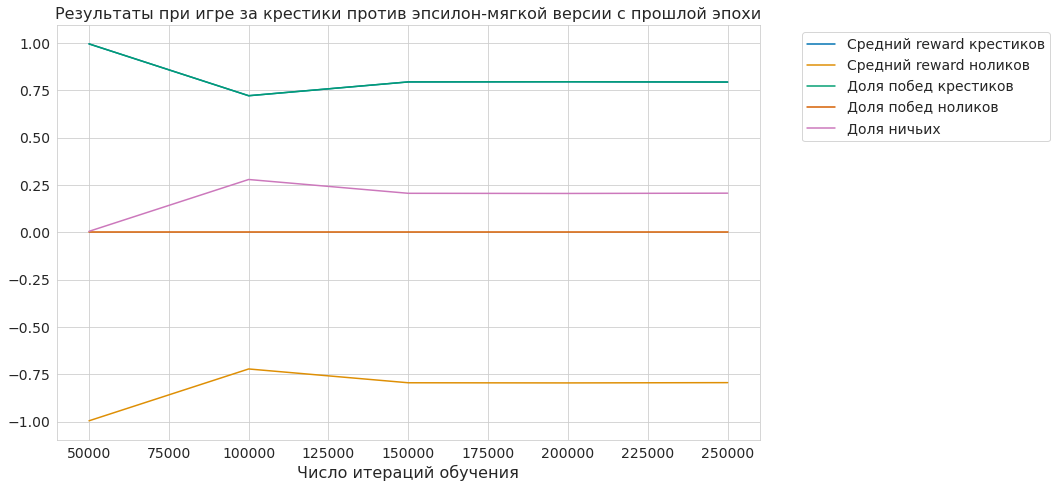

In [54]:
plot_history(self_play_crosses_history,
            'Результаты при игре за крестики против эпсилон-мягкой версии с прошлой эпохи',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

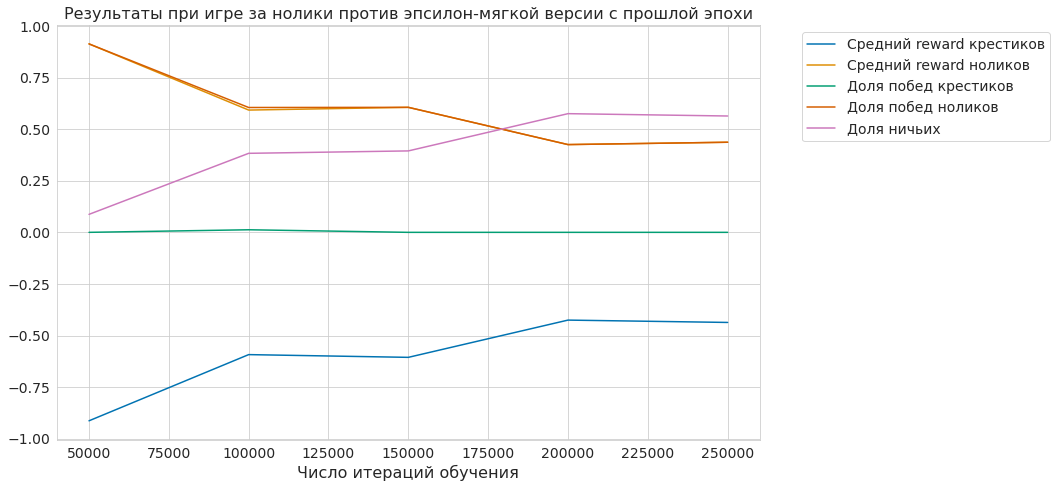

In [55]:
plot_history(self_play_naughts_history,
            'Результаты при игре за нолики против эпсилон-мягкой версии с прошлой эпохи',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

In [56]:
print('Доли поражений при игре за нолики')
self_play_naughts_history.crosses_win_fractions

Доли поражений при игре за нолики


[0.0, 0.01248, 0.0, 0.0, 0.0]

Если теперь обученная стратегия сыграет против самой себя?

In [57]:
self_play_greedy_strategy = EpsilonGreedyStrategy(0, self_play_trainer.train_strategy.Q)

In [58]:
show_test_game(env, self_play_greedy_strategy, self_play_greedy_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -

---- ---- ---- -
| o |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x | o |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
| x | o |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| x | o |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| x | o

А против случайной?

In [59]:
evaluate_strategy(env, crosses_strategy=self_play_greedy_strategy, naughts_strategy=random_strategy, num_iterations=EVAL_ITER)

100%|██████████| 50000/50000 [00:47<00:00, 1062.21it/s]


EvaluationResults(crosses_mean_reward=0.98734, naughts_mean_reward=-0.98734, crosses_win_fraction=0.98734, naughts_win_fraction=0.0, tie_fraction=0.01266)

In [60]:
evaluate_strategy(env, crosses_strategy=random_strategy, naughts_strategy=self_play_greedy_strategy, num_iterations=EVAL_ITER)

100%|██████████| 50000/50000 [00:48<00:00, 1040.19it/s]


EvaluationResults(crosses_mean_reward=-0.91758, naughts_mean_reward=0.91758, crosses_win_fraction=0.0, naughts_win_fraction=0.91758, tie_fraction=0.08242)

Случайной стратегии больше не проигрываем даже при игре за нолики, и партии выглядят хорошо

## Пункт 2
Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

## Учим стратегию играть против самой себя на поле 4x4
Для победы будем требовать лниню из 4 элементов

In [81]:
env = TicTacToeTableWrapper(TicTacToe(4,4,4))

In [82]:
show_test_game(env, random_strategy, random_strategy, True)

---- ---- ---- ---- -
| o | x | x | o | 
---- ---- ---- ---- -
| x | o | o | o | 
---- ---- ---- ---- -
| x | x | o | x | 
---- ---- ---- ---- -
| o | x | o | x | 
---- ---- ---- ---- -
Ничья!


In [83]:
evaluate_strategy(env, random_strategy, random_strategy, 50000)

100%|██████████| 50000/50000 [01:40<00:00, 497.15it/s]


EvaluationResults(crosses_mean_reward=0.04676, naughts_mean_reward=-0.04676, crosses_win_fraction=0.31488, naughts_win_fraction=0.26812, tie_fraction=0.417)

In [99]:
EPSILON = 0.25
ALPHA = 0.1

In [100]:
self_play_Q_4x4 = AfterstatesTableFunctionWrapper(RunningExp(alpha=ALPHA))

In [101]:
self_play_train_strategy_4x4 = EpsilonGreedyStrategy(epsilon=EPSILON, Q=self_play_Q_4x4)

In [102]:
self_play_trainer_4x4 = QlearningSelfTrainer(env, self_play_train_strategy_4x4)

In [103]:
TRAIN_ITER = int(1e7)
EVAL_ITER = int(2e5)
NUM_CHECKPOINTS = 10

In [104]:
self_play_crosses_history_4x4, self_play_naughts_history_4x4 = self_train_and_eval(self_play_trainer_4x4,
                                                                                    TRAIN_ITER,
                                                                                    EVAL_ITER,
                                                                                    NUM_CHECKPOINTS)

Trainer: QlearningSelfTrainer(epsilon=0.25, alpha=0.1)
Training EpsilonGreedyStrategy(epsilon=0.25) versus EpsilonGreedyStrategy(epsilon=0.25)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 of 10 (1000000 runs)


100%|██████████| 200000/200000 [07:06<00:00, 468.74it/s]


GreedyStrategy results over 200000 games as crosses versus RandomStrategy:
EvaluationResults(crosses_mean_reward=0.655695, naughts_mean_reward=-0.655695, crosses_win_fraction=0.71497, naughts_win_fraction=0.059275, tie_fraction=0.225755)



100%|██████████| 200000/200000 [07:31<00:00, 442.52it/s]

GreedyStrategy results over 200000 games as naughts versus RandomStrategy:
EvaluationResults(crosses_mean_reward=-0.47537, naughts_mean_reward=0.47537, crosses_win_fraction=0.113475, naughts_win_fraction=0.588845, tie_fraction=0.29768)
GreedyStrategy from current epoch as crosses versus RandomStrategy:


---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | x |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | x |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | x |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | x |   |   | 
---- ---- ---- ---- -
|   | o | o |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | x |   |   | 
---- ---- ---- ---- -
| x | o | o |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
| 

Epoch:  10%|█         | 1/10 [1:11:44<10:45:40, 4304.45s/it]

Epoch 2 of 10 (1000000 runs)


100%|██████████| 200000/200000 [06:54<00:00, 481.97it/s]

GreedyStrategy results over 200000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=0.85117, naughts_mean_reward=-0.85117, crosses_win_fraction=0.866345, naughts_win_fraction=0.015175, tie_fraction=0.11848)




100%|██████████| 200000/200000 [08:53<00:00, 374.53it/s]

GreedyStrategy results over 200000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.407405, naughts_mean_reward=0.407405, crosses_win_fraction=0.043925, naughts_win_fraction=0.45133, tie_fraction=0.504745)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
|   | x |   |   | 
---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |


Epoch:  20%|██        | 2/10 [2:24:55<9:37:22, 4330.33s/it] 

Epoch 3 of 10 (1000000 runs)


100%|██████████| 200000/200000 [07:40<00:00, 434.52it/s]

GreedyStrategy results over 200000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=0.8195, naughts_mean_reward=-0.8195, crosses_win_fraction=0.823445, naughts_win_fraction=0.003945, tie_fraction=0.17261)




100%|██████████| 200000/200000 [09:18<00:00, 357.95it/s]

GreedyStrategy results over 200000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.52417, naughts_mean_reward=0.52417, crosses_win_fraction=0.03555, naughts_win_fraction=0.55972, tie_fraction=0.40473)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | x |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | x |   |   | 
---- ---- ---- ---- -
| o |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | x |   |   | 
---- ---- ---- ---- -
| o |   |   | x | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |


Epoch:  30%|███       | 3/10 [3:45:10<8:42:09, 4475.71s/it]

Epoch 4 of 10 (1000000 runs)


100%|██████████| 200000/200000 [07:42<00:00, 432.16it/s]

GreedyStrategy results over 200000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=0.82496, naughts_mean_reward=-0.82496, crosses_win_fraction=0.835785, naughts_win_fraction=0.010825, tie_fraction=0.15339)




100%|██████████| 200000/200000 [09:00<00:00, 369.78it/s]


GreedyStrategy results over 200000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.615765, naughts_mean_reward=0.615765, crosses_win_fraction=0.03579, naughts_win_fraction=0.651555, tie_fraction=0.312655)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   | x | o |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |

Epoch:  40%|████      | 4/10 [5:05:12<7:37:22, 4573.80s/it]

Epoch 5 of 10 (1000000 runs)


100%|██████████| 200000/200000 [08:55<00:00, 373.49it/s]

GreedyStrategy results over 200000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=0.42345, naughts_mean_reward=-0.42345, crosses_win_fraction=0.454405, naughts_win_fraction=0.030955, tie_fraction=0.51464)




100%|██████████| 200000/200000 [07:41<00:00, 433.02it/s]

GreedyStrategy results over 200000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.73066, naughts_mean_reward=0.73066, crosses_win_fraction=0.02419, naughts_win_fraction=0.75485, tie_fraction=0.22096)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -
|   |   | o |


Epoch:  50%|█████     | 5/10 [6:23:00<6:23:29, 4601.95s/it]

Epoch 6 of 10 (1000000 runs)


100%|██████████| 200000/200000 [08:12<00:00, 406.42it/s]


GreedyStrategy results over 200000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=0.75368, naughts_mean_reward=-0.75368, crosses_win_fraction=0.77431, naughts_win_fraction=0.02063, tie_fraction=0.20506)



100%|██████████| 200000/200000 [09:08<00:00, 364.59it/s]

GreedyStrategy results over 200000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.352885, naughts_mean_reward=0.352885, crosses_win_fraction=0.00737, naughts_win_fraction=0.360255, tie_fraction=0.632375)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:


---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
| x |   | x |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
| 

Epoch:  60%|██████    | 6/10 [7:39:50<5:06:57, 4604.48s/it]

Epoch 7 of 10 (1000000 runs)


100%|██████████| 200000/200000 [08:31<00:00, 391.38it/s]

GreedyStrategy results over 200000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=0.6753, naughts_mean_reward=-0.6753, crosses_win_fraction=0.701695, naughts_win_fraction=0.026395, tie_fraction=0.27191)




100%|██████████| 200000/200000 [08:56<00:00, 372.99it/s]

GreedyStrategy results over 200000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.658795, naughts_mean_reward=0.658795, crosses_win_fraction=0.01248, naughts_win_fraction=0.671275, tie_fraction=0.316245)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | x |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | o | x |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | o | x |   | 
---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   | o |


Epoch:  70%|███████   | 7/10 [8:59:09<3:52:31, 4650.65s/it]

Epoch 8 of 10 (1000000 runs)


100%|██████████| 200000/200000 [09:11<00:00, 362.89it/s]


GreedyStrategy results over 200000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=0.604345, naughts_mean_reward=-0.604345, crosses_win_fraction=0.60902, naughts_win_fraction=0.004675, tie_fraction=0.386305)



100%|██████████| 200000/200000 [09:41<00:00, 343.84it/s]

GreedyStrategy results over 200000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.383055, naughts_mean_reward=0.383055, crosses_win_fraction=0.03653, naughts_win_fraction=0.419585, tie_fraction=0.543885)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -
|   | o |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -
|   | o | x |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x |   |   |   | 
---- ---- ---- ---- -
|   | o |


Epoch:  80%|████████  | 8/10 [10:29:01<2:42:26, 4873.01s/it]

Epoch 9 of 10 (1000000 runs)


100%|██████████| 200000/200000 [12:05<00:00, 275.52it/s]

GreedyStrategy results over 200000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=0.454065, naughts_mean_reward=-0.454065, crosses_win_fraction=0.45788, naughts_win_fraction=0.003815, tie_fraction=0.538305)




100%|██████████| 200000/200000 [12:41<00:00, 262.62it/s]

GreedyStrategy results over 200000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.31238, naughts_mean_reward=0.31238, crosses_win_fraction=0.01153, naughts_win_fraction=0.32391, tie_fraction=0.66456)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | x |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| o |   |   |   | 
---- ---- ---- ---- -
|   |   | x |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| o |   |   |   | 
---- ---- ---- ---- -
|   |   | x | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| o |   |   | o | 
---- ---- ---- ---- -
|   |   | x |


Epoch:  90%|█████████ | 9/10 [12:09:13<1:26:54, 5214.77s/it]

Epoch 10 of 10 (1000000 runs)


100%|██████████| 200000/200000 [18:13<00:00, 182.86it/s]

GreedyStrategy results over 200000 games as crosses versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=0.548015, naughts_mean_reward=-0.548015, crosses_win_fraction=0.552715, naughts_win_fraction=0.0047, tie_fraction=0.442585)




100%|██████████| 200000/200000 [18:39<00:00, 178.61it/s]

GreedyStrategy results over 200000 games as naughts versus EpsilonGreedyStrategy(epsilon=0.25) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.303475, naughts_mean_reward=0.303475, crosses_win_fraction=0.015375, naughts_win_fraction=0.31885, tie_fraction=0.665775)
GreedyStrategy from current epoch as crosses versus GreedyStrategy from previous epoch:


---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
| o |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   | o |   | 
---- ---- ---- ---- -
| o |   | x |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
| x | o |   | x | 
---- ---- ---- ---- -
| 

Epoch: 100%|██████████| 10/10 [14:39:35<00:00, 5277.51s/it] 


По партиям видно, как со временем качество игры растёт, но результаты не впечатляют

In [105]:
path = 'models/self_play_q_4x4.pkl'
save(self_play_trainer_4x4.train_strategy.Q, path)
# Проверяем, что всё работает
self_play_trainer_4x4.train_strategy.Q = load(path)

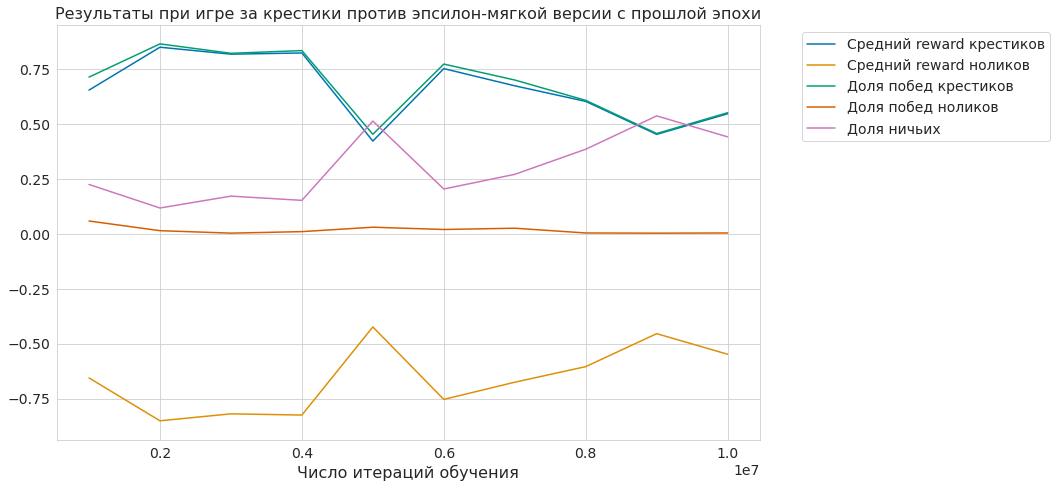

In [106]:
plot_history(self_play_crosses_history_4x4,
            'Результаты при игре за крестики против эпсилон-мягкой версии с прошлой эпохи',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

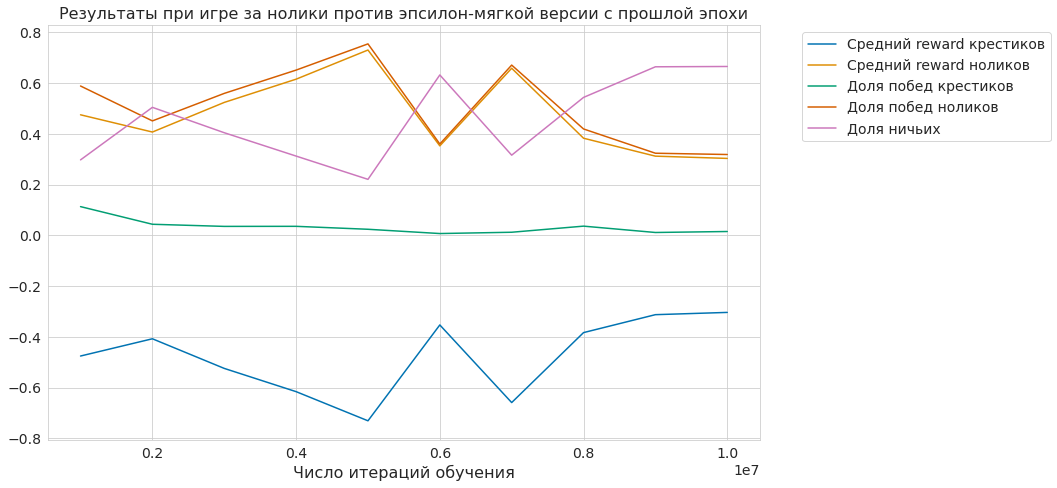

In [107]:
plot_history(self_play_naughts_history_4x4,
            'Результаты при игре за нолики против эпсилон-мягкой версии с прошлой эпохи',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

In [108]:
print('Доли поражений при игре за нолики')
self_play_naughts_history_4x4.crosses_win_fractions

Доли поражений при игре за нолики


[0.113475,
 0.043925,
 0.03555,
 0.03579,
 0.02419,
 0.00737,
 0.01248,
 0.03653,
 0.01153,
 0.015375]

Если теперь обученная стратегия сыграет против самой себя?

In [109]:
self_play_greedy_strategy_4x4 = EpsilonGreedyStrategy(0, self_play_trainer_4x4.train_strategy.Q)

In [110]:
show_test_game(env, self_play_greedy_strategy_4x4, self_play_greedy_strategy_4x4)

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   | o | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -
|   |   |   | o | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   | o | x | 
---- ---- ---- ---- -
|   |   |   | o | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
|   |   |   | x | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   | o | x | 
---- ---- ---- ---- -
|   |   |   | o | 
---- ---- ---- ---- -
|   |   |   |   | 
---- ---- ---- ---- -
| x |   |   | x | 
---- ---- ---- ---- -

---- ---- ---- ---- -
|   |   | o | x | 
---- ---- ---- ---- -
| 

А против случайной?

In [111]:
evaluate_strategy(env, crosses_strategy=self_play_greedy_strategy_4x4,
                  naughts_strategy=random_strategy, num_iterations=EVAL_ITER)

100%|██████████| 200000/200000 [12:02<00:00, 276.68it/s]


EvaluationResults(crosses_mean_reward=0.84456, naughts_mean_reward=-0.84456, crosses_win_fraction=0.84844, naughts_win_fraction=0.00388, tie_fraction=0.14768)

In [112]:
evaluate_strategy(env, crosses_strategy=random_strategy,
                  naughts_strategy=self_play_greedy_strategy_4x4, num_iterations=EVAL_ITER)

100%|██████████| 200000/200000 [10:44<00:00, 310.54it/s]


EvaluationResults(crosses_mean_reward=-0.751435, naughts_mean_reward=0.751435, crosses_win_fraction=0.00798, naughts_win_fraction=0.759415, tie_fraction=0.232605)